### for final compilation of sequences from different sub categories

In [1]:
import os, sys, warnings, re, glob2, itertools, string, random, math

import numpy as np
import pandas as pd
import scipy
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib_venn import venn3

In [ ]:
# if there's an issue with loading fonts
# delete ~/.cache/matplotlib
# and reload matplotlib

### I.I housekeeping

In [2]:
# set up working directories (do not run twice)
base_dir = os.path.split(os.getcwd())[0]
sys.path.insert(0, os.path.join(os.getcwd(),"utils"))
os.chdir(base_dir)
scriptdir=os.path.join(base_dir, "scripts")

In [4]:
from utils import specseq_plot_utils,sequence_annotator, mpra_CRE_utils, mpra_plot_utils
specseq_plot_utils.set_manuscript_params() # max 7pt

### I.II load data

In [12]:
# peak lists
fimo_th = 2.5e-3
# full peak list with annotation
mpraAnnot_df = pd.read_csv(os.path.join(base_dir, "peaksets", f"allCRE_annotation.withMutants.fimo{fimo_th}.tsv"), sep="\t", header=0)
# motif position information
allMonomerSites = pd.read_csv(os.path.join(base_dir, "peaksets", f"allMonomerMutatedSites.fimo{fimo_th}.tsv"), sep="\t", header=0)
allDimerSites = pd.read_csv(os.path.join(base_dir, "peaksets", f"allDimerMutatedSites.fimo{fimo_th}.tsv"), sep="\t", header=0)
# 20 controls trimmed to 134bp
trimmed_control_CREs = pd.read_csv(os.path.join(base_dir, "peaksets", "positiveControls.trimmed.tsv"), sep="\t", header=0)
# 150 scrambles
scrambled_CREs = pd.read_csv(os.path.join(base_dir, "peaksets", "scrambled150.withShuffles.tsv"), sep="\t", header=0)

# fastas
allCRE_fasta = sequence_annotator.read_fasta(os.path.join(base_dir, "sequences", "mpraAllCRE.fa"))
singleDimerMutants = sequence_annotator.read_fasta(os.path.join(base_dir, "sequences", f"mutatedCREs_fimo{fimo_th}", "mutatedCRE.k88n_olap.MEME.2.mutated.fa"))
singleMonomerMutants = sequence_annotator.read_fasta(os.path.join(base_dir, "sequences", f"mutatedCREs_fimo{fimo_th}", "mutatedCRE.CRX_Corbo.mutated.fa"))
doubleMutants = sequence_annotator.read_fasta(os.path.join(base_dir, "sequences", f"mutatedCREs_fimo{fimo_th}", "mutatedCRE.dimerMonomer.mutated.fa"))
trimmed_control_fasta = sequence_annotator.read_fasta(os.path.join(base_dir, "sequences", "positiveControls.trimmed.fa"))
scrambled_fasta = sequence_annotator.read_fasta(os.path.join(base_dir,"sequences", "scrambled150_shuffled.fa"))

# occupancy data
mu = 0.1
# unmaked occupancy landscape
unmasked_occupancy_df = pd.read_csv(os.path.join(base_dir, "predicted_occp", f"allCRE.unmasked.occupancy.mu{str(mu)}.tsv"), sep="\t", header=0)
# dimeric motif maksed occupancy landscape
masked_occupancy_df = pd.read_csv(os.path.join(base_dir, "predicted_occp", f"allCRE.masked.occupancy.mu{str(mu)}.tsv"), sep="\t", header=0)
mu = 9
# unmaked occupancy landscape
unmasked_occupancy_df2 = pd.read_csv(os.path.join(base_dir, "predicted_occp", f"allCRE.unmasked.occupancy.mu{str(mu)}.tsv"), sep="\t", header=0)
# dimeric motif maksed occupancy landscape
masked_occupancy_df2 = pd.read_csv(os.path.join(base_dir, "predicted_occp", f"allCRE.masked.occupancy.mu{str(mu)}.tsv"), sep="\t", header=0)

In [13]:
# subseting peaks
retinalGene_CRE = mpraAnnot_df.loc[lambda df: df.annotation == "RetinalGene"].copy().reset_index(drop=True)
e80a_gained = mpraAnnot_df.loc[lambda df: df.annotation == "EGain"].copy().reset_index(drop=True)
e80a_lost = mpraAnnot_df.loc[lambda df: df.annotation == "ELost"].copy().reset_index(drop=True)
k88n_gained = mpraAnnot_df.loc[lambda df: df.annotation == "KGain"].copy().reset_index(drop=True)
k88nlost_CREs = mpraAnnot_df.loc[lambda df: df.annotation == "KLost"].copy().reset_index(drop=True)
notdiffbound_CREs = mpraAnnot_df.loc[lambda df: df.annotation == "NotDB"].copy().reset_index(drop=True)

#### scan for RE sites (if mutant contains RE site, need to get rid of all forms of the same CRE)

In [14]:
EcoRI="GAATTC"
SpeI="ACTAGT"
SphI="GCATGC"
EagI="CGGCCG"

allCRE_REsite_matches = mpra_CRE_utils.find_REsite_match(allCRE_fasta, RE_list=[EcoRI,SpeI,SphI,EagI])
#sequence_annotator.write_fasta(allCRE_REsite_matches, os.path.join(mpraout_dir, "sequences", "allCRE.REmatched.fa"))

Looking for matches: GAATTC|ACTAGT|GCATGC|CGGCCG


In [262]:
# extract the set of peaks we are going to do random selection from
candidate_CREs = mpraAnnot_df.loc[lambda df: (df.annotation == "KLost")|(df.annotation == "NotDB")].copy().reset_index(drop=True)
testing_CREs = mpraAnnot_df.loc[lambda df: ~df["peak.id"].isin(candidate_CREs["peak.id"])].copy().reset_index(drop=True)

In [265]:
# drop CREs that contain RE sites
candidate_CREs = candidate_CREs.loc[lambda df: ~df["peak.id"].isin(allCRE_REsite_matches.index),:].reset_index(drop=True)
testing_CREs = testing_CREs.loc[lambda df: ~df["peak.id"].isin(allCRE_REsite_matches.index),:].reset_index(drop=True)

In [277]:
len(candidate_CREs)==len(set(candidate_CREs["peak.id"])-set(allCRE_REsite_matches.index))

True

In [276]:
candidate_CREs.groupby(["annotation"]).count()["peak.id"].to_frame()

,peak.id
annotation,
KLost,4764
NotDB,3376


In [278]:
testing_CREs.groupby(["annotation"]).count()["peak.id"].to_frame()

,peak.id
annotation,
EGain,203
ELost,283
KGain,430
RetinalGene,45


### I.III some additional functions

#### replicate each CRE N times

In [15]:
def make_N_CREs(CRE_df, N):
    CRE_df = CRE_df.copy()

    reps = [int(N)]*len(CRE_df.index)
    replicated_CRE_df = CRE_df.loc[np.repeat(CRE_df.index.values, reps)]

    return replicated_CRE_df

### II. random selection of N peaks from the notDB category

In [284]:
# a complete list of the index of all CREs
allcandidateCREs = range(1, len(candidate_CREs))
# randomly draw n elements from the list
subset_candidateCREs = random.sample(allcandidateCREs, 850)
# sort index
subset_candidateCREs.sort()
# retrieve annotation and fasta of CREs drawed
subset_candidateCREs_df = candidate_CREs.iloc[subset_candidateCREs,:].copy().reset_index(drop=True)

In [285]:
subset_candidateCREs_df["peak.id"].isin(allCRE_REsite_matches.index).sum()

0

In [312]:
testing_CREs["peak.id"].isin(allCRE_REsite_matches.index).sum()

0

In [286]:
subset_candidateCREs_stats = subset_candidateCREs_df.groupby(["annotation"]).count().loc[:,["peak.id","mutD.FASTA","mutM.FASTA","mutDM.FASTA"]]
print(f"total CREs in the notDB category to be tested: {str(subset_candidateCREs_stats.sum().sum())}")
subset_candidateCREs_stats = pd.concat([subset_candidateCREs_stats, subset_candidateCREs_stats.sum(axis=0).to_frame().rename(columns={0:"Sum"}).transpose()], axis=0)
display(subset_candidateCREs_stats)

total CREs in the notDB category to be tested: 1792


,peak.id,mutD.FASTA,mutM.FASTA,mutDM.FASTA
KLost,487,64,415,54
NotDB,363,41,329,39
Sum,850,105,744,93


In [134]:
testing_CREs_stats = testing_CREs.groupby(["annotation"]).count().loc[:,["peak.id","mutD.FASTA","mutM.FASTA","mutDM.FASTA"]]
print(f"total CREs in the DB category to be tested: {str(testing_CREs_stats.sum().sum())}")
testing_CREs_stats = pd.concat([testing_CREs_stats, testing_CREs_stats.sum(axis=0).to_frame().rename(columns={0:"Sum"}).transpose()], axis=0)
display(testing_CREs_stats)

total CREs in the DB category to be tested: 2559


,peak.id,mutD.FASTA,mutM.FASTA,mutDM.FASTA
EGain,203,9,194,9
ELost,283,109,234,88
KGain,430,264,402,244
RetinalGene,45,3,40,2
Sum,961,385,870,343


In [289]:
sum_mpraCREs_stats = pd.concat([testing_CREs_stats.loc["Sum",:].rename("DB"), subset_candidateCREs_stats.loc["Sum",:].rename("notDB")], axis=1).transpose()
print(f"total CREs to be tested: {str(sum_mpraCREs_stats.sum().sum())}")
sum_mpraCREs_stats = pd.concat([sum_mpraCREs_stats, sum_mpraCREs_stats.sum(axis=0).to_frame().rename(columns={0:"Sum"}).transpose()], axis=0)
display(sum_mpraCREs_stats)

total CREs to be tested: 4351


,peak.id,mutD.FASTA,mutM.FASTA,mutDM.FASTA
DB,961,385,870,343
notDB,850,105,744,93
Sum,1811,490,1614,436


In [290]:
# check any overlap
len(set(subset_candidateCREs_df["peak.id"]) - set(testing_CREs["peak.id"]))

850

In [293]:
# retrieve fasta
subset_candidateCREs_fasta = allCRE_fasta[subset_candidateCREs_df["peak.id"]]

In [294]:
# temporarily write to file in case of any unexpected
subset_candidateCREs_df.to_csv(os.path.join(base_dir, "peaksets", "selectedCandidateSubset.tsv"), sep="\t", header=True, index=False)
sequence_annotator.write_fasta(subset_candidateCREs_fasta, os.path.join(base_dir,"sequences", "selectedCandidateSubset.fa"))

### III. before going further, take a quick look at the motif contents of all groups

In [313]:
# compile all testing CREs and sort by coordinates
all_testing_CREs = pd.concat([subset_candidateCREs_df,testing_CREs], axis=0).sort_values(by=["seqnames","start"]).reset_index(drop=True)
# retireve all testing fasta
all_testing_fasta = allCRE_fasta[all_testing_CREs["peak.id"]].copy()

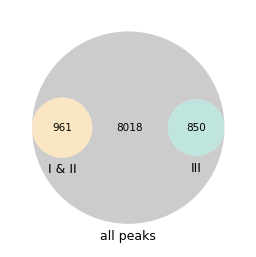

In [152]:
fig, ax = plt.subplots(figsize=(2,2), dpi=150)
venn3(subsets=[set(mpraAnnot_df["peak.id"]), set(testing_CREs["peak.id"]), set(subset_candidateCREs_df["peak.id"])], set_labels=('all peaks', 'I & II', "III"), set_colors=("grey","#DC9514","#0E927B"), ax=ax)

In [153]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(base_dir, "plots", "category.venn"), timestamp=False, tight_layout=False)

In [ ]:
# histogram
fig2, ax2 = plt.subplots(figsize=(2,2), dpi=150)
fig2, ax2 = mpra_plot_utils.make_predictedOccp_histo(masked_occupancy_df2, motif_name="Lee_2010_CRX", histocolor="grey", alpha=.6, bins=50, density=True, xticks=None, yticks=None, figax=(fig2, ax2))
fig2, ax2 = mpra_plot_utils.make_predictedOccp_histo(masked_occupancy_df2.loc[lambda df: df.label.isin(all_testing_CREs["peak.id"])], motif_name="Lee_2010_CRX", histocolor="#DC9514", alpha=.6, bins=50, density=True, xticks=None, yticks=None, figax=(fig2, ax2))

ax2.set_title("Predicted Occupancy\nfor WT CRX HD Motifs \u03BC=9")
ax2.legend(["background", "selected"])

In [315]:
specseq_plot_utils.save_fig(fig2, prefix=os.path.join(base_dir, "plots", "CRX_Corbo.predOccup.mu9"), timestamp=False, tight_layout=False)

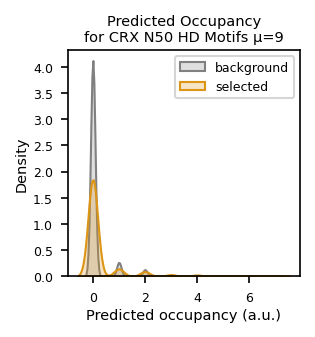

In [316]:
# histogram
fig2, ax2 = plt.subplots(figsize=(2,2), dpi=150)
fig2, ax2 = mpra_plot_utils.make_predictedOccp_histo(masked_occupancy_df2, motif_name="k88n_olap.DREME.1", histocolor="grey", alpha=.6, bins=50, density=True, xticks=None, yticks=None, figax=(fig2, ax2))
fig2, ax2 = mpra_plot_utils.make_predictedOccp_histo(masked_occupancy_df2.loc[lambda df: df.label.isin(all_testing_CREs["peak.id"])], motif_name="k88n_olap.DREME.1", histocolor="#DC9514", alpha=.6, bins=50, density=True, xticks=None, yticks=None, figax=(fig2, ax2))

ax2.set_title("Predicted Occupancy\nfor CRX N50 HD Motifs \u03BC=9")
ax2.legend(["background", "selected"])

In [317]:
specseq_plot_utils.save_fig(fig2, prefix=os.path.join(base_dir, "plots", "k88n_olap.DREME.1.predOccup.mu9"), timestamp=False, tight_layout=False)

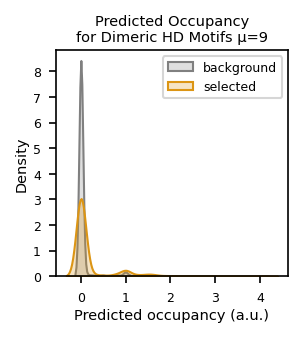

In [318]:
# histogram
fig2, ax2 = plt.subplots(figsize=(2,2), dpi=150)
fig2, ax2 = mpra_plot_utils.make_predictedOccp_histo(unmasked_occupancy_df2, motif_name="k88n_olap.MEME.2", histocolor="grey", alpha=.6, bins=14, density=True, xticks=None, yticks=None, figax=(fig2, ax2))
fig2, ax2 = mpra_plot_utils.make_predictedOccp_histo(unmasked_occupancy_df2.loc[lambda df: df.label.isin(all_testing_CREs["peak.id"])], motif_name="k88n_olap.MEME.2", histocolor="#DC9514", alpha=.6, bins=14, density=True, xticks=None, yticks=None, figax=(fig2, ax2))

ax2.set_title("Predicted Occupancy\nfor Dimeric HD Motifs \u03BC=9")
ax2.legend(["background", "selected"])

In [319]:
specseq_plot_utils.save_fig(fig2, prefix=os.path.join(base_dir, "plots", "k88n_olap.MEME.2.predOccup.mu9"), timestamp=False, tight_layout=False)

Text(0.5, 1.0, 'Motif Occurrence for WT CRX Motifs\nFIMO $\\itp$-$\\itvalue$ < $\\it0.001$')

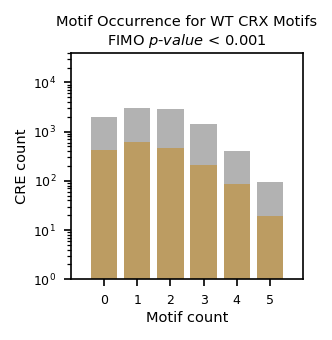

In [320]:
# histogram
fig3, ax3 = plt.subplots(figsize=(2,2), dpi=150)
fig3, ax3 = mpra_plot_utils.make_motifOccurence_bar(mpraAnnot_df, motif_name="CRX_Corbo", histocolor="grey", alpha=.6, density=False, xticks=None, yticks=None, figax=(fig3, ax3))
fig3, ax3 = mpra_plot_utils.make_motifOccurence_bar(all_testing_CREs, motif_name="CRX_Corbo", histocolor="#DC9514", alpha=.6, density=False, xticks=None, yticks=None, figax=(fig3, ax3))
ax3.set_yscale('log')
ax3.set_xlim(-1, 6)
ax3.set_ylim(1,4e4)
ax3.set_xticks(ticks=range(6))
ax3.set_xticklabels([str(x) for x in range(6)])

ax3.set_title(f"Motif Occurrence for WT CRX Motifs\nFIMO $\itp$-$\itvalue$ < $\it0.001$")

In [321]:
specseq_plot_utils.save_fig(fig3, prefix=os.path.join(base_dir, "plots", "CRX_Corbo.occurrence.fimo0.001"), timestamp=False, tight_layout=False)

Text(0.5, 1.0, 'Motif Occurrence for CRX N50 Motifs\nFIMO $\\itp$-$\\itvalue$ < $\\it0.001$')

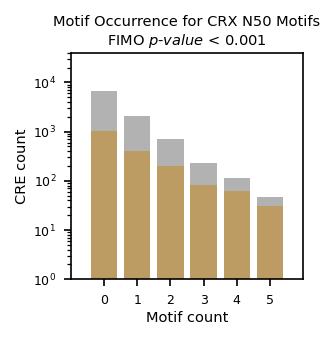

In [322]:
# histogram
fig3, ax3 = plt.subplots(figsize=(2,2), dpi=150)
fig3, ax3 = mpra_plot_utils.make_motifOccurence_bar(mpraAnnot_df, motif_name="N50", histocolor="grey", alpha=.6, density=False, xticks=None, yticks=None, figax=(fig3, ax3))
fig3, ax3 = mpra_plot_utils.make_motifOccurence_bar(all_testing_CREs, motif_name="N50", histocolor="#DC9514", alpha=.6, density=False, xticks=None, yticks=None, figax=(fig3, ax3))
ax3.set_yscale('log')
ax3.set_xlim(-1, 6)
ax3.set_ylim(1, 4e4)
ax3.set_xticks(ticks=range(6))
ax3.set_xticklabels([str(x) for x in range(6)])

ax3.set_title("Motif Occurrence for CRX N50 Motifs\nFIMO $\itp$-$\itvalue$ < $\it0.001$")

In [323]:
specseq_plot_utils.save_fig(fig3, prefix=os.path.join(base_dir, "plots", "k88n_olap.DREME.1.occurrence.fimo0.001"), timestamp=False, tight_layout=False)

Text(0.5, 1.0, 'Motif Occurrence for Dimeric HD Motifs\nFIMO $\\itp$-$\\itvalue$ < $\\it0.001$')

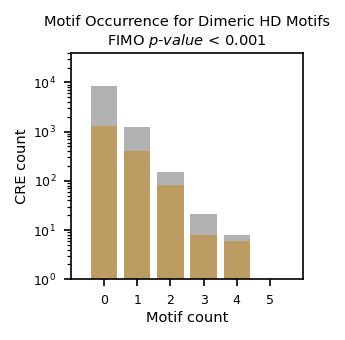

In [324]:
# histogram
fig3, ax3 = plt.subplots(figsize=(2,2), dpi=150)
fig3, ax3 = mpra_plot_utils.make_motifOccurence_bar(mpraAnnot_df, motif_name="HDdimer", histocolor="grey", alpha=.6, density=False, xticks=None, yticks=None, figax=(fig3, ax3))
fig3, ax3 = mpra_plot_utils.make_motifOccurence_bar(all_testing_CREs, motif_name="HDdimer", histocolor="#DC9514", alpha=.6, density=False, xticks=None, yticks=None, figax=(fig3, ax3))
ax3.set_yscale('log')
ax3.set_xlim(-1, 6)
ax3.set_ylim(1, 4e4)
ax3.set_xticks(ticks=range(6))
ax3.set_xticklabels([str(x) for x in range(6)])

ax3.set_title("Motif Occurrence for Dimeric HD Motifs\nFIMO $\itp$-$\itvalue$ < $\it0.001$")

In [325]:
specseq_plot_utils.save_fig(fig3, prefix=os.path.join(base_dir, "plots", "k88n_olap.MEME.2.occurrence.fimo0.001"), timestamp=False, tight_layout=False)

#### check GC contents of scrambles

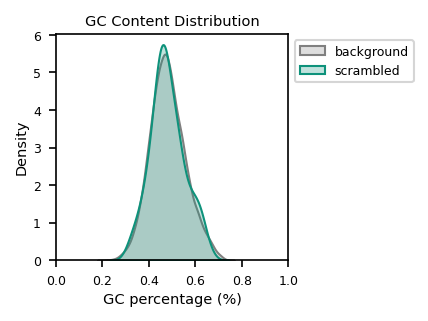

In [79]:
# histogram
fig4, ax4 = plt.subplots(figsize=(2,2), dpi=150)
_, fig4, ax4 = mpra_plot_utils.make_GC_histo(allCRE_fasta, histocolor="grey", alpha=0.6, bins=24, density=True, figax=(fig4,ax4))
_, fig4, ax4 = mpra_plot_utils.make_GC_histo(scrambled_fasta, histocolor="#0E927B", alpha=0.6, bins=24, density=True, figax=(fig4,ax4))

ax4.legend(["background", "scrambled"], loc='upper left', bbox_to_anchor=(1, 1))

In [ ]:
specseq_plot_utils.save_fig(fig4, prefix=os.path.join(base_dir, "plots", "scrambled.GCcontent"), timestamp=False, tight_layout=False)

### IV. assemble all sequences into one list and add barcodes

In [10]:
all_barcodes = pd.read_csv(os.path.join(base_dir,"barcodes","validated10bp_barcodes.txt"), header=None).rename(columns={0:"BC"})

#### there are some barcodes that ends with CGGC will create EagI site and needs to be drop

In [11]:
all_barcodes = all_barcodes[~all_barcodes.BC.apply(lambda row: row[-4:]=="CGGC")].reset_index(drop=True)

In [ ]:
all_barcodes.to_csv(os.path.join(base_dir,"barcodes","validated10bp_barcodes.txt"), index=False, header=False)

#### move these fouctions to the top, scan RE sites first then select CREs
#### alternatively, check #of match, then make up the reset

In [462]:
wt_df = all_testing_CREs.loc[:,["peak.id","seqnames","start","end","annotation","wt.FASTA"]].copy().rename(columns={"wt.FASTA":"FASTA"})
wt_df["motif"] = "WT"

dimer_df = all_testing_CREs.loc[:,["peak.id","seqnames","start","end","annotation","mutD.FASTA"]].copy().dropna().rename(columns={"mutD.FASTA":"FASTA"})
dimer_df["motif"] = "mutD"
monomer_df = all_testing_CREs.loc[:,["peak.id","seqnames","start","end","annotation","mutM.FASTA"]].copy().dropna().rename(columns={"mutM.FASTA":"FASTA"})
monomer_df["motif"] = "mutM"
double_df = all_testing_CREs.loc[:,["peak.id","seqnames","start","end","annotation","mutDM.FASTA"]].copy().dropna().rename(columns={"mutDM.FASTA":"FASTA"})
double_df["motif"] = "mutDM"

scrambled_df = scrambled_CREs.loc[:,["peak.id","seqnames","start","end","annotation","shuffled.FASTA"]].copy().rename(columns={"shuffled.FASTA":"FASTA"})
scrambled_df["motif"] = "scrambled"

In [473]:
mpra_library = pd.concat([wt_df,dimer_df,monomer_df,double_df,scrambled_df], axis=0).sort_values(by=["seqnames","start","motif"]).reset_index(drop=True)
mpra_library["start"] = mpra_library["start"].astype(int)
mpra_library["end"] = mpra_library["end"].astype(int)

In [474]:
# make sure no WT sequence containing a RE site is included in the first place
mpra_library["peak.id"].isin(allCRE_REsite_matches.index).sum()

0

In [475]:
# each CRE in the testing library gets 4 barcodes
mpra_library = make_N_CREs(mpra_library, 4)
mpra_library = pd.merge(mpra_library.reset_index(drop=True), all_barcodes[0:len(mpra_library)], left_index=True, right_index=True).copy()

In [476]:
mpra_library["label"] = mpra_library["seqnames"]+"-"+mpra_library["start"].astype(str)+"-"+mpra_library["end"].astype(str)+"_"+mpra_library["peak.id"]+"_"+mpra_library["annotation"]+"_"+mpra_library["motif"]+"_"+mpra_library["BC"]
mpra_library = mpra_library.loc[:,["peak.id","seqnames","start","end","annotation","motif","BC","FASTA","label"]]
mpra_library_fasta = mpra_library.loc[:,["label","FASTA"]].copy().set_index("label").squeeze()

In [477]:
mpra_library.to_csv(os.path.join(base_dir, "peaksets", f"hdmuts_library.fimo{fimo_th}.tsv"), sep="\t", header=True, index=False)

In [478]:
sequence_annotator.write_fasta(mpra_library_fasta, os.path.join(base_dir, "sequences", f"hdmuts_library_CREs.fimo{fimo_th}.fa"))

#### controls

In [ ]:
trimmed_control_fasta

In [182]:
control_df = trimmed_control_fasta.to_frame().reset_index().rename(columns={0:"FASTA"})
control_df["peak.id"] = ["peak."]+pd.Series(str(9841+x) for x in range(len(control_df.index)))
# run this merge only with control_CRE_df before replication of 6
control_df = pd.merge(trimmed_control_CREs, control_df.loc[:,["peak.id","FASTA"]], left_index=True, right_index=True)
control_df["motif"] = "WT"
control_df = control_df.loc[:,["peak.id","seqnames","start","end","annotation","FASTA","motif"]]

In [183]:
# each CRE in the control library gets 6 barcodes
control_df = make_N_CREs(control_df, 6)
control_df = pd.merge(control_df.reset_index(drop=True), all_barcodes[len(mpra_library):len(mpra_library)+len(control_df)].reset_index(drop=True), left_index=True, right_index=True).copy()

In [333]:
control_df["BC"] = all_barcodes[len(mpra_library):len(mpra_library)+len(control_df)].reset_index(drop=True)

In [334]:
control_df

,peak.id,seqnames,start,end,annotation,motif,BC,FASTA,label
0,peak.9841,chr14,20440153,20440286,control,WT,TGTATGCCGG,CTGTGAGCTGTTGAGATGGCTTAAAGAGCAAAGCTACTTACTGCTG...,chr14-20440153-20440286_peak.9841_control_WT_C...
1,peak.9841,chr14,20440153,20440286,control,WT,GCTTGATGAT,CTGTGAGCTGTTGAGATGGCTTAAAGAGCAAAGCTACTTACTGCTG...,chr14-20440153-20440286_peak.9841_control_WT_T...
2,peak.9841,chr14,20440153,20440286,control,WT,ACGGCGGTTA,CTGTGAGCTGTTGAGATGGCTTAAAGAGCAAAGCTACTTACTGCTG...,chr14-20440153-20440286_peak.9841_control_WT_C...
3,peak.9841,chr14,20440153,20440286,control,WT,TCTTCGTGCT,CTGTGAGCTGTTGAGATGGCTTAAAGAGCAAAGCTACTTACTGCTG...,chr14-20440153-20440286_peak.9841_control_WT_A...
4,peak.9841,chr14,20440153,20440286,control,WT,TAAGGTGACC,CTGTGAGCTGTTGAGATGGCTTAAAGAGCAAAGCTACTTACTGCTG...,chr14-20440153-20440286_peak.9841_control_WT_C...
...,...,...,...,...,...,...,...,...,...
115,peak.9860,chr11,120366335,120366468,control,WT,TAGAAGGATG,CTCTTCCCACACTCCCTGACAGCACCTTTCATGCTGCTAAATCCCC...,chr11-120366335-120366468_peak.9860_control_WT...
116,peak.9860,chr11,120366335,120366468,control,WT,GGTTAAGGTC,CTCTTCCCACACTCCCTGACAGCACCTTTCATGCTGCTAAATCCCC...,chr11-120366335-120366468_peak.9860_control_WT...
117,peak.9860,chr11,120366335,120366468,control,WT,GGTGCCTCAC,CTCTTCCCACACTCCCTGACAGCACCTTTCATGCTGCTAAATCCCC...,chr11-120366335-120366468_peak.9860_control_WT...
118,peak.9860,chr11,120366335,120366468,control,WT,TCGAGTTACG,CTCTTCCCACACTCCCTGACAGCACCTTTCATGCTGCTAAATCCCC...,chr11-120366335-120366468_peak.9860_control_WT...


In [335]:
control_df["label"] = control_df["seqnames"]+"-"+control_df["start"].astype(str)+"-"+control_df["end"].astype(str)+"_"+control_df["peak.id"]+"_"+control_df["annotation"]+"_"+control_df["motif"]+"_"+control_df["BC"]
control_df = control_df.loc[:,["peak.id","seqnames","start","end","annotation","motif","BC","FASTA","label"]]
control_fasta = control_df.loc[:,["label","FASTA"]].copy().set_index("label").squeeze()

In [336]:
mpra_CRE_utils.find_REsite_match(control_fasta, RE_list=[EcoRI,SpeI,SphI,EagI])

Looking for matches: GAATTC|ACTAGT|GCATGC|CGGCCG


Series([], Name: FASTA, dtype: object)

In [337]:
control_df.to_csv(os.path.join(base_dir, "peaksets", "positiveControls.trimmed.tsv"), sep="\t", header=True, index=False)

In [338]:
sequence_annotator.write_fasta(control_fasta, os.path.join(base_dir, "sequences", f"positiveControls.BCed.fa"))

### V. remove any CREs with undesirable sequence features

#### scan again for RE sites (if mutant contains RE site, need to get rid of all forms of the same CRE)

In [340]:
REmatched_fasta = mpra_CRE_utils.find_REsite_match(mpra_library_fasta, RE_list=[EcoRI,SpeI,SphI,EagI])

Looking for matches: GAATTC|ACTAGT|GCATGC|CGGCCG


In [341]:
sequence_annotator.write_fasta(REmatched_fasta, os.path.join(base_dir, "sequences", "hdmuts_library.REmatached.fa"))

#### all de novo cut site matches that of SpeI "ACTAGT" because of mutation at TAATAGTNTTA site

In [366]:
REmatched_peaks = REmatched_fasta.index.str.split(pat="_", expand=True).to_frame().index.get_level_values(1).unique()
REmatched_df = mpraAnnot_df.loc[lambda df: df["peak.id"].isin(REmatched_peaks),:]
REmatched_df

,peak.id,seqnames,start,end,summit,width,strand,CRX_Corbo,N50,HDmono,HDdimer,NRL,AP1,annotation,wt.FASTA,mutD.FASTA,mutM.FASTA,mutDM.FASTA
741,peak.742,chr10,50707955.0,50708088.0,50708022.0,134.0,+,1,0,0,2,1,1,KGain,CAAGATGAAATTGACCCTGATAATTATATTACTTTAAATCTCTTTT...,CAAGATGAAATTGACCCTGATACTTATAGTACTTTAAATCTCTTTT...,CAAGATGAAATTGACCCTGATAATTATATTACTTTAAATCTCTTTT...,CAAGATGAAATTGACCCTGATACTTATAGTACTTTAAATCTCTTTT...
971,peak.972,chr10,101815879.0,101816012.0,101815946.0,134.0,+,2,2,2,1,1,0,KGain,GATTAGTGCTGAGAGATAATCGTGTTGGATTATCATTTTATTCAAA...,GATTAGTGCTGAGAGATAATCGTGTTGGATTATCATTTTATTCAAA...,GATTAGTGCTGAGAGATAATCGTGTTGGAGTATCATTTTATTCAAA...,GATTAGTGCTGAGAGATAATCGTGTTGGAGTATCATTTTATTCAAA...
1733,peak.1735,chr11,107241384.0,107241517.0,107241451.0,134.0,+,1,2,0,1,0,2,KGain,AAGATCTTGGCCCAGCTACAGGAGAGCTTGCATCTGGGAAGTAATA...,AAGATCTTGGCCCAGCTACAGGAGAGCTTGCATCTGGGAAGTACTA...,AAGATCTTGGCCCAGCTACAGGAGAGCTTGCATCTGGGAAGTAATA...,AAGATCTTGGCCCAGCTACAGGAGAGCTTGCATCTGGGAAGTACTA...
1940,peak.1943,chr12,32456940.0,32457073.0,32457007.0,134.0,+,1,1,1,2,1,2,KGain,TCATCTCAAGTAATCAGAATGTGGCATAGTGCCAGAGATGCAATTT...,TCATCTCAAGTAATCAGAATGTGGCATAGTGCCAGAGATGCAATTT...,TCATCTCAAGTACTCAGAATGTGGCATAGTGCCAGAGATGCAATTT...,TCATCTCAAGTACTCAGAATGTGGCATAGTGCCAGAGATGCAATTT...
5231,peak.5238,chr2,75237128.0,75237261.0,75237195.0,134.0,+,1,2,2,2,1,0,KGain,ATGAACACTGCTTTAAATTATAGTCCCAATAGCTTACAACAGTTAC...,ATGAACACTGCTTTAAATTATAGTCCCAATAGCTTACAACAGTTAC...,ATGAACACTGCTTTAAAGTATAGTCCCAATAGCTTACAACAGTTAC...,ATGAACACTGCTTTAAAGTATAGTCCCAATAGCTTACAACAGTTAC...
5741,peak.5748,chr3,20232334.0,20232467.0,20232401.0,134.0,+,4,6,2,1,0,1,KGain,TGTATACTAATTAGAATTAGTATAAGACTATTAGTATATATACTAA...,TGTATACTAATTAGAATTAGTATACGACTAGTAGTATATATACTAA...,TGTATACTACTTAGAAGTAGTATAAGACTATTAGTATATATACTAC...,TGTATACTACTTAGAAGTAGTATACGACTAGTAGTATATATACTAC...
5912,peak.5919,chr3,87352599.0,87352732.0,87352666.0,134.0,+,2,2,2,1,0,1,KGain,ATGAGCATAACCAAGCACTTCTGACTGGATTAAAGTCCTGTTCTGC...,ATGAGCATAACCAAGCACTTCTGACTGGATTAAAGTCCTGTTCTGC...,ATGAGCATAACCAAGCACTTCTGACTGGAGTAAAGTCCTGTTCTGC...,ATGAGCATAACCAAGCACTTCTGACTGGAGTAAAGTCCTGTTCTGC...
6178,peak.6187,chr4,6448663.0,6448796.0,6448730.0,134.0,+,0,0,0,1,1,1,KGain,AGTAGCGCAGTGCTGTTGAGAGGAGAGCAGGGCACACCAGTGACTG...,AGTAGCGCAGTGCTGTTGAGAGGAGAGCAGGGCACACCAGTGACTG...,NaN,NaN
6305,peak.6314,chr4,53125785.0,53125918.0,53125852.0,134.0,+,3,2,2,1,0,0,KGain,TAATATCTCATTATACTGTGCATAATAATATAATACTATTATAATT...,TAATATCTCATTATACTGTGCATAATAATATACTACTAGTATAATT...,TAATATCTCAGTATACTGTGCATAATAATATAATACTATTATACGT...,TAATATCTCAGTATACTGTGCATAATAATATACTACTAGTATACGT...
6367,peak.6376,chr4,81924363.0,81924496.0,81924430.0,134.0,+,2,2,1,1,2,3,KGain,AGATTCTAAGCCCCATTTAATAGTATTAGCTCTTAATTACCTGTGA...,AGATTCTAAGCCCCATTTACTAGTAGTAGCTCTTAATTACCTGTGA...,AGATTCTACGCCCCATTTAATAGTATTAGCTCTTACTTACCTGTGA...,AGATTCTACGCCCCATTTACTAGTAGTAGCTCTTACTTACCTGTGA...


In [343]:
REmatched_df.to_csv(os.path.join(base_dir, "peaksets", "hdmuts_library.REmatached.tsv"), sep="\t", header=True, index=False)

#### since I want to keep these sequence, I am changing the TAAT core to TCCT to avoid creation of new RE site

In [373]:
REmatched_dimerSites = allDimerSites.loc[lambda df: (df["sequence_name"].isin(REmatched_peaks)),:].copy().reset_index(drop=True)
#REmatched_dimerSites

In [374]:
# pick out those that matches "AGT" spacer
REmatched_dimerSites = REmatched_dimerSites.loc[lambda df: df["matched_sequence"].str.contains(pat="TAGT"),:].copy().drop_duplicates(subset=["sequence_name","start"]).reset_index(drop=True)

In [385]:
REmatched_dimerSites["new.matched_sequence"] = REmatched_dimerSites.apply(lambda x: x["mutated_seq"] if x["strand"]=="+" else sequence_annotator.rev_comp(x["mutated_seq"]), axis=1)

In [389]:
REmatched_dimerSites2 = REmatched_dimerSites.drop(columns=["matched_sequence","mutated_seq"]).rename(columns={"new.matched_sequence":"matched_sequence"})

#### without specifying core motif, mutating AA to CC

In [414]:
REmatched_mutDfasta = singleDimerMutants[list(set(singleDimerMutants.index).intersection(set(REmatched_dimerSites2["sequence_name"]+".mutD")))]
REmatched_mutDfasta.index = REmatched_mutDfasta.index.str.strip(".mutD")
REmatched_mutDMfasta = doubleMutants[list(set(doubleMutants.index).intersection(set(REmatched_dimerSites2["sequence_name"]+".mutDM")))]
REmatched_mutDMfasta.index = REmatched_mutDMfasta.index.str.strip(".mutDM")

In [465]:
REmatched_dimer, REmatched_dimer_fasta = mpra_CRE_utils.find_and_mutate_motif(REmatched_mutDfasta, REmatched_dimerSites2, motif_name="k88n_olap.MEME.2", mutantmotif_dict={2:"C", 3:"C", 9:"G", 10:"G"})

In [448]:
REmatched_dimer

,peak.id,motif,start,end,strand,score,match_seq,mutated_seq
0,peak.6376,k88n_olap.MEME.2,18,28,+,14.71,TACTAGTAGTA,TCCTAGTAGGA
1,peak.7734,k88n_olap.MEME.2,94,104,+,5.12,TACTAGTCGTA,TCCTAGTCGGA
2,peak.6314,k88n_olap.MEME.2,31,41,-,14.71,TACTAGTAGTA,TCCTACTAGGA
3,peak.5238,k88n_olap.MEME.2,79,89,-,14.71,TACTAGTAGTA,TCCTACTAGGA
4,peak.5238,k88n_olap.MEME.2,62,72,-,14.71,TACTAGTAGTA,TCCTACTAGGA
5,peak.5748,k88n_olap.MEME.2,23,33,-,5.12,TACTAGTCGTA,TCCGACTAGGA
6,peak.5919,k88n_olap.MEME.2,121,131,+,14.71,TACTAGTAGTA,TCCTAGTAGGA
7,peak.9099,k88n_olap.MEME.2,49,59,+,5.12,TACTAGTGGTA,TCCTAGTGGGA
8,peak.6187,k88n_olap.MEME.2,57,67,+,14.71,TACTAGTAGTA,TCCTAGTAGGA
9,peak.1943,k88n_olap.MEME.2,90,100,+,5.12,TACTAGTGGTA,TCCTAGTGGGA


In [466]:
REmatched_double, REmatched_double_fasta = mpra_CRE_utils.find_and_mutate_motif(REmatched_mutDMfasta, REmatched_dimerSites2, motif_name="k88n_olap.MEME.2", mutantmotif_dict={2:"C", 3:"C", 9:"G", 10:"G"})

In [467]:
REmatched_double

,peak.id,motif,start,end,strand,score,match_seq,mutated_seq
0,peak.6972,k88n_olap.MEME.2,77,87,-,5.12,TACTAGTCGTA,TCCGACTAGGA
1,peak.972,k88n_olap.MEME.2,47,57,-,14.71,TACTAGTAGTA,TCCTACTAGGA
2,peak.6376,k88n_olap.MEME.2,18,28,+,14.71,TACTAGTAGTA,TCCTAGTAGGA
3,peak.5748,k88n_olap.MEME.2,23,33,-,5.12,TACTAGTCGTA,TCCGACTAGGA
4,peak.9099,k88n_olap.MEME.2,49,59,+,5.12,TACTAGTGGTA,TCCTAGTGGGA
5,peak.1735,k88n_olap.MEME.2,42,52,-,14.71,TACTAGTAGTA,TCCTACTAGGA
6,peak.1943,k88n_olap.MEME.2,90,100,+,5.12,TACTAGTGGTA,TCCTAGTGGGA
7,peak.6314,k88n_olap.MEME.2,31,41,-,14.71,TACTAGTAGTA,TCCTACTAGGA
8,peak.9744,k88n_olap.MEME.2,113,123,+,5.12,TACTAGTGGTA,TCCTAGTGGGA
9,peak.742,k88n_olap.MEME.2,52,62,-,14.71,TACTAGTAGTA,TCCTACTAGGA


In [424]:
allMonomerSites.loc[lambda df: df["sequence_name"]=="peak.6314",:]

,sequence_name,motif_id,start,stop,strand,score,matched_sequence,mutated_seq
14061,peak.6314,k88n_olap.DREME.1,42,48,-,11.51000,TTAATTA,TACTTAA
14062,peak.6314,k88n_olap.DREME.1,7,13,+,11.03000,CTCATTA,CTCAGTA
14063,peak.6314,k88n_olap.DREME.1,41,47,+,3.32000,ATAATTA,ATAAGTA
14064,peak.6314,k88n_olap.DREME.1,42,48,-,2.15000,TTACTTA,TACGTAA
14065,peak.6314,CRX_Corbo,54,61,-,6.21429,CTAATTTC,GAAAGTAG
14066,peak.6314,CRX_Corbo,108,115,+,9.34921,ATAATCCT,ATACTCCT
14067,peak.6314,k88n_olap.DREME.1,46,52,-,2.15000,TGAATTA,TACTTCA
14068,peak.6314,CRX_Corbo,45,52,+,6.80159,TTAATTCA,TTACTTCA


In [419]:
allCRE_fasta["peak.6314"]

'TAATATCTCATTATACTGTGCATAATAATATAATACTATTATAATTAATTCAGGAAATTAGGTCTCAGAAACATTGAATGTTTTGTCTGAGATGTCCAGACTTGAAAATAATCCTATCTTGGCTATGGACAGCA'

In [451]:
REmatched_dimer_fasta["peak.6314"]

'TAATATCTCATTATACTGTGCATAATAATATCCTACTAGGATAATTAATTCAGGAAATTAGGTCTCAGAAACATTGAATGTTTTGTCTGAGATGTCCAGACTTGAAAATAATCCTATCTTGGCTATGGACAGCA'

In [468]:
REmatched_double_fasta["peak.6314"]

'TAATATCTCAGTATACTGTGCATAATAATATCCTACTAGGATACGTACTTCAGGAAAGTAGGTCTCAGAAACATTGAATGTTTTGTCTGAGATGTCCAGACTTGAAAATACTCCTATCTTGGCTATGGACAGCA'

#### update the annotation table and corresponding fasta data

In [469]:
for idx in REmatched_dimerSites2["sequence_name"]:
    if idx in REmatched_dimer_fasta.index:
        all_testing_CREs.loc[lambda df: df["peak.id"]==idx,"mutD.FASTA"]=REmatched_dimer_fasta[idx]
        mpraAnnot_df.loc[lambda df: df["peak.id"]==idx,"mutD.FASTA"]=REmatched_dimer_fasta[idx]
    if idx in REmatched_double_fasta.index:
        all_testing_CREs.loc[lambda df: df["peak.id"]==idx,"mutDM.FASTA"]=REmatched_double_fasta[idx]
        mpraAnnot_df.loc[lambda df: df["peak.id"]==idx,"mutDM.FASTA"]=REmatched_double_fasta[idx]

#### now redo the BCing steps with the new mutated fasta sequences

In [471]:
all_testing_CREs.to_csv(os.path.join(base_dir, "peaksets", f"hdmuts_library.noBC.fimo{fimo_th}.tsv"), sep="\t", header=True, index=False)
mpraAnnot_df.to_csv(os.path.join(base_dir, "peaksets", f"allCRE_annotation.withMutants.fimo{fimo_th}.tsv"), sep="\t", header=True, index=False)

In [456]:
REmatched_dimer_fasta.index = REmatched_dimer_fasta.index+".mutD"
singleDimerMutants[list(set(singleDimerMutants.index).intersection(set(REmatched_dimerSites2["sequence_name"]+".mutD")))] = REmatched_dimer_fasta

In [457]:
REmatched_double_fasta.index = REmatched_double_fasta.index+".mutDM"
doubleMutants[list(set(doubleMutants.index).intersection(set(REmatched_dimerSites2["sequence_name"]+".mutDM")))] = REmatched_double_fasta

In [459]:
sequence_annotator.write_fasta(singleDimerMutants, os.path.join(base_dir, "sequences", f"mutatedCREs_fimo{fimo_th}", "mutatedCRE.k88n_olap.MEME.2.mutated.fa"))
sequence_annotator.write_fasta(doubleMutants, os.path.join(base_dir, "sequences", f"mutatedCREs_fimo{fimo_th}", "mutatedCRE.dimerMonomer.mutated.fa"))

### VI. assemble all components and rename with chr-start-stop_peak.id_annotation_motif_barcode

In [8]:
# note the actual primer sequences comtain partial restriction enzyme site, so be careful not to duplicate those sequences
primerF = "GTAGCGTCTGTCCGT" #15
primerR = "CTGTAGTAGTAGTTGG" #16
primerR_revcomp = sequence_annotator.rev_comp(primerR)
padding="C" # for padding betweeing SpeI and SphI site
basalFiller="GTCCCCCTTGCAGAATTACATGCAACCCTCAACTGCTCGATCTAGCTCTCTAATGGCAAGATCCGCAAGGGCAAAACAGACTATTACCGCGAGATCCGAACGAAATGAAGATTGAACATGGCTGTAATTGGGCT"

#### Oligo: primerF + EcoRI + CRE + SpeI + C + SphI + 10bp BC + EagI + primerR

In [592]:
mpra_library["fullOligo"] = primerF+EcoRI+mpra_library["FASTA"]+SpeI+"C"+SphI+mpra_library["BC"]+EagI+primerR_revcomp
control_df["fullOligo"] = primerF+EcoRI+control_df["FASTA"]+SpeI+"C"+SphI+control_df["BC"]+EagI+primerR_revcomp

In [593]:
mpra_library_oligo = mpra_library.loc[:,["label","fullOligo"]].copy().set_index("label").squeeze()
control_oligo = control_df.loc[:,["label","fullOligo"]].copy().set_index("label").squeeze()

In [523]:
sequence_annotator.write_fasta(mpra_library_oligo, os.path.join(base_dir, "sequences", f"hdmuts_library.Oligos.fimo{fimo_th}.fa"))
sequence_annotator.write_fasta(control_oligo, os.path.join(base_dir, "sequences", f"hdmuts_control.Oligos.fimo{fimo_th}.fa"))

In [514]:
basal_df = pd.DataFrame(index=range(0,20), columns=["peak.id","fullOligo"])
basal_df["peak.id"] = pd.Series(["basal."+str(n) for n in range(1,21)])
basal_df["BC"] = all_barcodes[len(mpra_library)+len(control_df):len(mpra_library)+len(control_df)+20].reset_index(drop=True)
basal_df["fullOligo"] = primerF+EcoRI+SpeI+"C"+basalFiller+SphI+basal_df["BC"]+EagI+primerR_revcomp
basal_df["label"] = basal_df["peak.id"]+"_"+basal_df["BC"]

In [526]:
len(basal_df.at[0,"fullOligo"])

66

In [517]:
basal_oligo = basal_df.loc[:,["label","fullOligo"]].copy().set_index("label").squeeze()

In [520]:
sequence_annotator.write_fasta(basal_oligo, os.path.join(base_dir, "sequences", "hdmuts_basal.Oligos.fa"))

### VII. to meet the 18k limit, drop all CREs with bizarre motif contents

In [564]:
checkMotifContent = all_testing_CREs.loc[lambda df: (df["CRX_Corbo"]>5)|(df["N50"]>5)|(df["HDdimer"]>5),:].copy()
#checkMotifContent.to_csv(os.path.join(base_dir,"peaksets",f"checkMotifContents.fimo{fimo_th}.tsv"), sep="\t", header=True, index=False)

In [565]:
# total number of sequences to remove from the mpra library oligos
checkMotifContent.loc[:,checkMotifContent.columns.str.contains("FASTA")].notnull().sum().sum()*4

224

In [574]:
set(scrambled_CREs["peak.id"].str.strip("_shuff")).intersection(set(checkMotifContent["peak.id"]))

{'peak.4249'}

In [605]:
filtered_mpra_library = mpra_library.loc[lambda df: ~((df["peak.id"].isin(checkMotifContent["peak.id"])) & (~df["label"].str.contains("scrambled"))),:]

In [608]:
filtered_mpra_library_oligo = filtered_mpra_library.loc[:,["label","fullOligo"]].copy().set_index("label").squeeze()

In [610]:
len(mpra_library_oligo) - len(filtered_mpra_library)

224

In [609]:
len(filtered_mpra_library_oligo) + len(control_oligo) + len(basal_oligo)

17920

In [611]:
sequence_annotator.write_fasta(filtered_mpra_library_oligo, os.path.join(base_dir, "sequences", f"hdmuts_library.Oligos.fimo{fimo_th}.filtered.fa"))